In [1]:
%load_ext autoreload
%autoreload 2

In [150]:
from fsd_path_planning.demo.streamlit_demo.common import get_cones_for_configuration
import numpy as np
import matplotlib.pyplot as plt
from fsd_path_planning.utils.math_utils import rotate, angle_from_2d_vector

In [195]:
position, direction, cones = get_cones_for_configuration("Hairpin Extreme", do_shuffle=True)

from pathlib import Path
position, direction, cones = eval(Path('/home/papalotis/repos/fsd-path-planning/example_data.txt').read_text())

cones = [np.array(cone).reshape(-1,2) for cone in cones]

In [196]:
cones_together = np.row_stack(cones)

idxs = np.random.default_rng(0).random(len(cones_together)).argsort()


cones_together = cones_together[idxs]

(-5.2417541475, 68.80199579750001, -30.294162, 39.418338000000006)

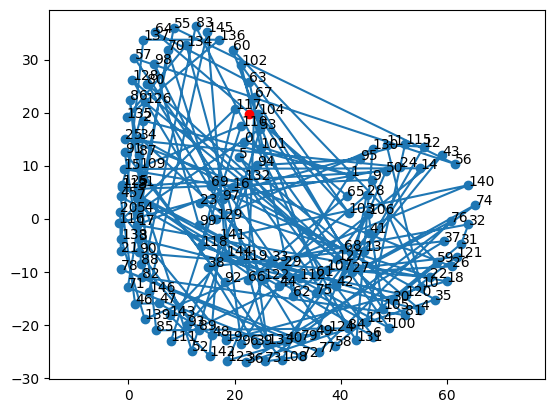

In [197]:

mask_keep = np.ones(len(cones_together), dtype=bool)
mask_keep[1] = False

cones_together = cones_together[mask_keep]
plt.plot(*cones_together.T, "o-")
plt.plot(*position, "ro")
for i, (x,y) in enumerate(cones_together):
    plt.text(x, y, str(i))

plt.axis("equal")

(-23.550890075497847,
 50.524649098518125,
 -35.36204402851401,
 38.66576366333371)

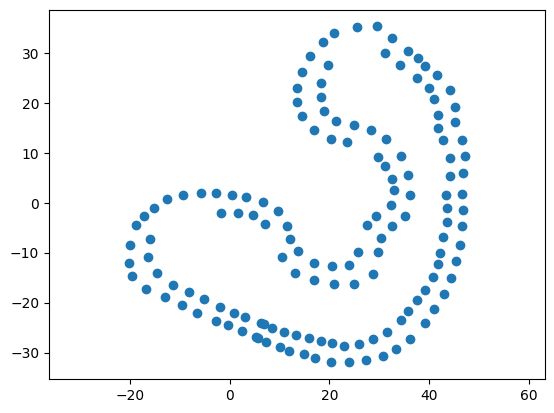

In [198]:
cones_relative = rotate(cones_together - position, -angle_from_2d_vector(direction))

plt.plot(*cones_relative.T, "o")
plt.axis("equal")

In [199]:
from fsd_path_planning.sorting_cones.trace_sorter.core_trace_sorter import TraceSorter
from fsd_path_planning.utils.cone_types import ConeTypes

In [214]:
ts = TraceSorter(max_n_neighbors=8, max_dist=8.0, max_dist_to_first=10.0, max_length=10, threshold_directional_angle=np.deg2rad(40),
        threshold_absolute_angle=np.deg2rad(70))

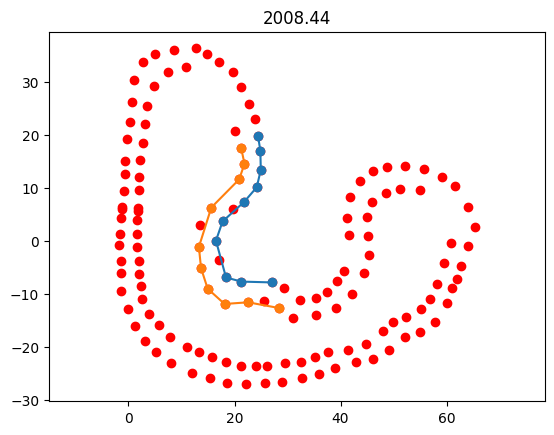

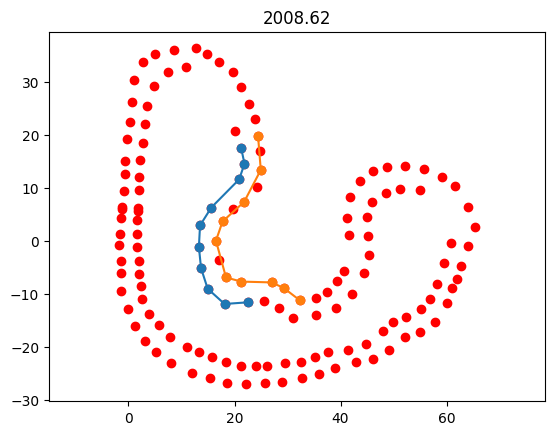

In [219]:
from fsd_path_planning.sorting_cones.trace_sorter.cost_function import cost_configurations


sort_order = [[ConeTypes.LEFT, ConeTypes.RIGHT], [ConeTypes.RIGHT, ConeTypes.LEFT]]

results = []

for first, second in sort_order:
    points_first, indices_first = ts.sort(cones_together, first, position, direction)

    mask_is_not_in_first = np.ones(len(cones_together), dtype=bool)
    mask_is_not_in_first[indices_first] = False

    cones_together_for_second = cones_together[mask_is_not_in_first]

    points_second, indices_second = ts.sort(cones_together_for_second, second, position, direction)

    cost_1 = cost_configurations(points_first, np.arange(len(points_first))[None], ConeTypes.LEFT, direction, return_individual_costs=False)
    cost_2 = cost_configurations(points_second, np.arange(len(points_second))[None], ConeTypes.RIGHT, direction, return_individual_costs=False)

    plt.plot(*cones_together.T, "ro")
    plt.plot(*cones_together[indices_first].T, "o-")
    plt.plot(*cones_together_for_second[indices_second].T, "o-")
    plt.title(f"{cost_1.item()+cost_2.item():.2f}")
    plt.axis("equal")
    plt.show()

    left_points = points_first if first == ConeTypes.LEFT else points_second
    right_points = points_second if second == ConeTypes.RIGHT else points_first

    results.append((left_points, right_points))
    


In [224]:
from fsd_path_planning.sorting_cones.trace_sorter.line_segment_intersection import pairwise_segment_intersection, number_of_intersections

def intersection_between_two_traces(trace_left: np.ndarray, trace_right: np.ndarray):
    
    cost_left = cost_configurations(trace_left, np.arange(len(trace_left))[None], ConeTypes.LEFT, direction, return_individual_costs=False)[0]
    cost_right = cost_configurations(trace_right, np.arange(len(trace_right))[None], ConeTypes.RIGHT, direction, return_individual_costs=False)[0]

    starts = np.row_stack([trace_left[:-1], trace_right[:-1]])
    ends = np.row_stack([trace_left[1:], trace_right[1:]])

    n_intersections_ignore = len(trace_left) - 2 + len(trace_right) - 2
    raw_intersections = pairwise_segment_intersection(starts, ends)

    n = number_of_intersections(raw_intersections) - n_intersections_ignore

    return_value = (n, cost_left + cost_right)
    # print(f"n_intersections: {n}, cost: {cost_left + cost_right:.2f}")
    return return_value


left_cones, right_cones = min(results, key=lambda x: intersection_between_two_traces(*x))
    

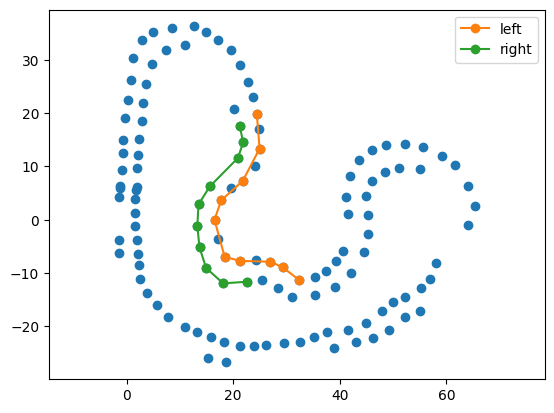

In [225]:
plt.plot(*cones_together.T, "o")
plt.plot(*left_cones.T, "o-", label="left")
plt.plot(*right_cones.T, "o-", label="right")
plt.axis("equal")
plt.legend()

In [226]:
def coloress_sorting(all_cones: np.ndarray, position: np.ndarray, direction: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Sorts the cones into left and right cones. The first cone is always the left cone.
    :param all_cones: The cones to sort
    :param position: The position of the car
    :param direction: The direction of the car
    :return: The left and right cones
    """
    ts = TraceSorter(max_n_neighbors=6, max_dist=10.0, max_dist_to_first=10.0, max_length=10, threshold_directional_angle=np.deg2rad(40),
        threshold_absolute_angle=np.deg2rad(70))

    sort_order = [[ConeTypes.LEFT, ConeTypes.RIGHT], [ConeTypes.RIGHT, ConeTypes.LEFT]]

    results = []

    for first, second in sort_order:
        points_first, indices_first = ts.sort(all_cones, first, position, direction)

        mask_is_not_in_first = np.ones(len(all_cones), dtype=bool)
        mask_is_not_in_first[indices_first] = False

        cones_together_for_second = all_cones[mask_is_not_in_first]

        points_second, indices_second = ts.sort(cones_together_for_second, second, position, direction)

        left_points, right_points = (points_first, points_second)
        if first == ConeTypes.RIGHT:
            left_points, right_points = (points_second, points_first)
        

        results.append((left_points, right_points))
    
    left_cones, right_cones = min(results, key=lambda x: intersection_between_two_traces(*x))
    
    return left_cones, right_cones

In [227]:
from fsd_path_planning.demo.json_demo import load_data_json
from tqdm import tqdm

demo_positions, demo_directions, demo_cones = load_data_json()

it = list(enumerate(zip(demo_positions, demo_directions, demo_cones)))

for i, (demo_positions_i, demo_directions_i, demo_cones_i) in tqdm(it):
    demo_cones_i = [np.array(cones_of_type).reshape(-1,2) for cones_of_type in demo_cones_i]
    cones_together = np.row_stack(demo_cones_i)

    left_cones, right_cones = coloress_sorting(cones_together, demo_positions_i, demo_directions_i)

    plt.plot(*cones_together.T, "o")
    plt.plot(*demo_positions_i, "ro")
    plt.plot(*left_cones.T, "o-", label="left")
    plt.plot(*right_cones.T, "o-", label="right")
    plt.axis("equal")
    plt.title(f"{i}")
    plt.savefig(f"frames/frame_{i:04d}.png")
    plt.close()
    # plt.show()

 40%|████      | 177/440 [00:57<01:20,  3.28it/s]/home/papalotis/repos/fsd-path-planning/fsd_path_planning/sorting_cones/trace_sorter/cost_function.py:75: RuntimeWarning: invalid value encountered in divide
  costs: FloatArray = angles_as_cost_filtered.sum(
100%|██████████| 440/440 [09:21<00:00,  1.28s/it]


n_intersections: 1, cost: 30.30
n_intersections: 1, cost: 33.16


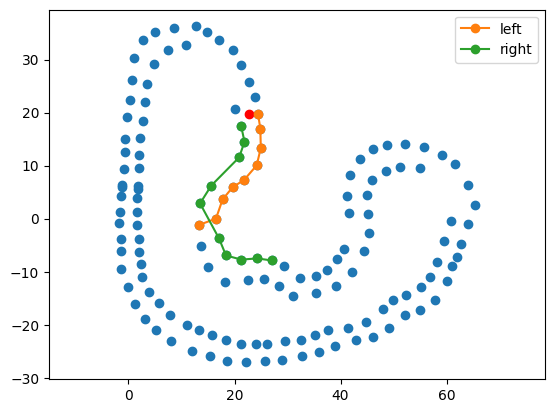

In [188]:
_, (pos, dir_, cones) = it[291]

all_cones = np.row_stack([np.array(c).reshape(-1,2) for c in cones])

left_cones, right_cones = coloress_sorting(all_cones, pos, dir_)

plt.plot(*all_cones.T, "o")
plt.plot(*pos, "ro")
plt.plot(*left_cones.T, "o-", label="left")
plt.plot(*right_cones.T, "o-", label="right")
plt.axis("equal")
plt.legend()

In [190]:
print(repr(it[291][1]))

(array([22.73382568, 19.70239258]), array([ 0.3101254 , -0.95069566]), [array([], dtype=float64), array([[  2.06137085,  12.06208801],
       [  2.24887085,  15.12458801],
       [  1.62387085,   3.81208801],
       [  2.81137085,  18.49958801],
       [  1.99887085,   9.62458801],
       [  3.12387085,  21.93708801],
       [  3.56137085,  25.37458801],
       [  4.81137085,  29.24958801],
       [  7.37387085,  31.87458801],
       [ 10.91782737,  32.70692137],
       [ 21.24887085,  17.49958801],
       [ 21.88205023,  14.49969913],
       [ 20.13978407,  20.73465422],
       [ 20.87387085,  11.56208801],
       [ 13.27945776,  -1.18799202],
       [ 13.49887085,   2.87458801],
       [ 13.68637085,  -5.18791199],
       [ 15.62387085,   6.24958801],
       [ 14.93637085,  -9.06291199],
       [  1.56137085,   1.24958801],
       [  1.93637085,  -3.87541199],
       [  1.62387085,  -1.18791199],
       [  2.06137085,  -6.37541199],
       [  2.31137085,  -8.56291199],
       [  2.49